# Implementation of MobileNetv2+SSD<br>
This is an implementation of the MobileNetv2 + SSD architecture for a relatively simpler task of determining bounding boxes for MNIST images embedded in a box. Each box contains only one digit(28x28 MNIST embedded into a 224x224 box) as of now, but the number of predictions per image can be expanded easily (the training outputs need to modified). Also, no data augmentation has been used till now (Colab kept crashing when I increased the dataset size beyond 1000, so the initial amount of data present was sufficient. The crashes might have been due to high traffic, but I haven't confirmed it).<p>
In the earlier implementation, the ground truth data contained information about only one bounding box, which meant only one prediction per image ( reference https://colab.research.google.com/github/rs9899/mySSDimplementation/blob/master/MobileNetSSD_v2.ipynb#scrollTo=xWBzDsvkDqx5). For me, it also reduced the training signal and the model was overfitting. So I changed the outputs to a prediction for each default box (as it should be, from what I understood from the SSD paper). Although the initial implementation is good for the purposes for understanding the model.

Comments mentioned throughout the code mention what needs to change if the model inputs or outputs are changed.

## Import libraries

In [1]:
import os
from datetime import datetime
import numpy as np
from tensorflow.keras import layers
import tensorflow as tf
import numpy.matlib
from PIL import Image
from keras import backend as K
from scipy.special import softmax
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# import Bottleneck

2022-02-15 19:09:32.134996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/z/GWT/gap_sdk/install/workstation/lib
2022-02-15 19:09:32.135016: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Define Bottleneck Residual layer for MobileNet<br>
Using the same parameters as mentioned in the paper

In [2]:
class Bottleneck(tf.keras.Model):
  def __init__(self, expansion, filters, stride, block_id, alpha=1, ):
    super(Bottleneck, self).__init__(name="Bottleneck_" + block_id)
    self.expansion = expansion
    self.alpha = alpha
    self.output_channels = self.alpha * filters
    self.stride = stride
    self.out = None  # there was some problem with the eager execution

    prefix = 'Bottleneck_{}_'.format(block_id)
    self.prefix = prefix
    # expansion
    self.expand_BN = layers.BatchNormalization(name=prefix + 'expand_BN')
    self.expand_ReLU = layers.ReLU(max_value=6, name=prefix + 'expand_ReLU')

    #conv
    self.Conv = layers.DepthwiseConv2D(kernel_size=3, padding='same', strides=self.stride, use_bias=False, name=prefix + 'conv')
    self.Conv_BN = layers.BatchNormalization(name=prefix + 'conv_BN')
    self.Conv_ReLU = layers.ReLU(max_value=6, name=prefix + 'conv_ReLU')

    #project
    self.project = layers.Conv2D(filters=self.output_channels, kernel_size=1, use_bias=False, name='contract')
    self.project_BN = layers.BatchNormalization(name=prefix + 'contract_BN')

    # dimensions need to be the same for residual connection
    self.residual = layers.Add(name=prefix + 'residual')

  def build(self, input_shape):
    self.d = input_shape[-1]
    self.expand = layers.Conv2D(filters=self.expansion * self.d, kernel_size=1, use_bias=False, name=self.prefix + 'expand')

  def call(self, inputs):
    x = self.expand(inputs)
    x = self.expand_BN(x)
    x = self.expand_ReLU(x)
    self.out = x

    x = self.Conv(x)
    x = self.Conv_BN(x)
    x = self.Conv_ReLU(x)

    x = self.project(x)
    x = self.project_BN(x)

    if self.output_channels == self.d and self.stride == 1:
      x = self.residual([inputs, x])

    return x

  def model(self):
    x = tf.keras.Input(shape=(28, 28, 3))
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [3]:
class MobileNetv2(tf.keras.Model):
  def __init__(self, k=11):
    super(MobileNetv2, self).__init__()
    self.k = k

    self.pad = layers.ZeroPadding2D(padding=2, name='pad')
    self.conv_inp = layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), padding='valid', use_bias=False, name='conv')
    self.BN = layers.BatchNormalization(name='BN')
    self.ReLU = layers.ReLU(max_value=6, name='ReLU')

    self.B1_1 = Bottleneck(expansion=1, filters=16, stride=1, block_id='B1_1')

    self.B2_1 = Bottleneck(expansion=6, filters=24, stride=2, block_id='B2_1')
    self.B2_2 = Bottleneck(expansion=6, filters=24, stride=1, block_id='B2_2')

    self.B3_1 = Bottleneck(expansion=6, filters=32, stride=2, block_id='B3_1')
    self.B3_2 = Bottleneck(expansion=6, filters=32, stride=1, block_id='B3_2')
    self.B3_3 = Bottleneck(expansion=6, filters=32, stride=1, block_id='B3_3')

    self.B4_1 = Bottleneck(expansion=6, filters=64, stride=2, block_id='B4_1')
    self.B4_2 = Bottleneck(expansion=6, filters=64, stride=1, block_id='B4_2')
    self.B4_3 = Bottleneck(expansion=6, filters=64, stride=1, block_id='B4_3')
    self.B4_4 = Bottleneck(expansion=6, filters=64, stride=1, block_id='B4_4')

    self.B5_1 = Bottleneck(expansion=6, filters=96, stride=1, block_id='B5_1')
    self.B5_2 = Bottleneck(expansion=6, filters=96, stride=1, block_id='B5_2')
    self.B5_3 = Bottleneck(expansion=6, filters=96, stride=1, block_id='B5_3')

    self.B6_1 = Bottleneck(expansion=6, filters=160, stride=2, block_id='B6_1')
    self.B6_2 = Bottleneck(expansion=6, filters=160, stride=1, block_id='B6_2')
    self.B6_3 = Bottleneck(expansion=6, filters=160, stride=1, block_id='B6_3')

    self.B7_1 = Bottleneck(expansion=6, filters=320, stride=1, block_id='B7_1')

    self.conv_out = layers.Conv2D(filters=1280, kernel_size=1, strides=(1, 1), use_bias=False, name='conv_out')
    self.avgpool = layers.AveragePooling2D(pool_size=(7, 7), name='avg_pool')
    self.conv_seg = layers.Conv2D(filters=self.k, kernel_size=1, strides=(1, 1), use_bias=False, name='conv_seg')

  def call(self, inputs):
    x = self.conv_inp(inputs)
    x = self.BN(x)
    x = self.ReLU(x)

    x = self.B1_1(x)

    x = self.B2_1(x)
    x = self.B2_2(x)

    x = self.B3_1(x)
    x = self.B3_2(x)
    x = self.B3_3(x)

    x = self.B4_1(x)
    x = self.B4_2(x)
    x = self.B4_3(x)
    x = self.B4_4(x)

    x = self.B5_1(x)
    x = self.B5_2(x)
    x = self.B5_3(x)

    x = self.B6_1(x)
    x = self.B6_2(x)
    x = self.B6_3(x)

    x = self.B7_1(x)

    x = self.conv_out(x)
    x = self.avgpool(x)
    c4 = self.conv_seg(x)

    return c4

  def model(self):
    x = tf.keras.Input(shape=(224, 224, 3))
    return tf.keras.Model(inputs=x, outputs=self.call(x))

In [4]:
MobileNetv2().model().summary()

2022-02-15 19:09:33.455770: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-02-15 19:09:33.455794: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: z
2022-02-15 19:09:33.455799: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: z
2022-02-15 19:09:33.455846: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2022-02-15 19:09:33.455861: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2022-02-15 19:09:33.455866: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.47.3
2022-02-15 19:09:33.456177: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv (Conv2D)               (None, 111, 111, 32)      864       
                                                                 
 BN (BatchNormalization)     (None, 111, 111, 32)      128       
                                                                 
 ReLU (ReLU)                 (None, 111, 111, 32)      0         
                                                                 
 Bottleneck_B1_1 (Bottleneck  (None, 111, 111, 16)     2144      
 )                                                               
                                                                 
 Bottleneck_B2_1 (Bottleneck  (None, 56, 56, 24)       5568      
 )                                                           

## SSD
The default number of boxes per layer and resolution of each layer is different, since we are working with MNIST data and 224x224 image sizes.
To change the number of boxes per layer and layerWidths, some constraints need to be kept in mind which are mentioned in the later sections

In [8]:
class SSD(tf.keras.Model):
  def __init__(self, numBoxes=[4,6,6,6,4,4], layerWidth=[28,14,7,4,2,1], k=10+1+4):
    super(SSD,self).__init__()
    self.classes = k
    self.featureMaps = 6
    self.MobileNet = MobileNetv2(k=k)
    self.numBoxes = numBoxes
    self.layerWidth = layerWidth
    self.features = [None for _ in range(self.featureMaps)]
    self.classifiers = [None for _ in range(self.featureMaps)]

    self.conv1_1 = layers.Conv2D(256, 1, name='SSD_conv_1_1')
    self.conv1_2 = layers.Conv2D(512, 3, strides=(2,2), padding='same', name='SSD_conv_1_2')

    self.conv2_1 = layers.Conv2D(128, 1, name='SSD_conv_2_1')
    self.conv2_2 = layers.Conv2D(256, 3, strides=(2,2), padding='same', name='SSD_conv_2_2')

    self.conv3_1 = layers.Conv2D(128, 1, name='SSD_conv_3_1')
    self.conv3_2 = layers.Conv2D(256, 3, strides=(1,1), name='SSD_conv_3_2')

    self.conv4_1 = layers.Conv2D(128, 1, name='SSD_conv_4_1')
    self.conv4_2 = layers.Conv2D(256, 2, strides=(1,1), name='SSD_conv_4_2') # changed the kernel size to 2 since the output of the previous layer has width 3
    self.conv = []
    self.reshape = []

    for i in range(self.featureMaps):
      self.conv.append(layers.Conv2D(self.numBoxes[i]*self.classes, 3, padding='same', name='Classification_'+str(i)))
      self.reshape.append(layers.Reshape((self.layerWidth[i]*self.layerWidth[i]*self.numBoxes[i], self.classes),name='Reshape_classification_'+str(i)))

  def build(self, input_shape):
    self.MobileNet.build(input_shape)

  def call(self,inputs):
    x = inputs
    x = self.MobileNet(x)

    # get the convolved images at different resolutions
    self.features[0] = self.MobileNet.get_layer('Bottleneck_B4_1').out
    self.features[1] = self.MobileNet.get_layer('Bottleneck_B5_3').out
    self.features[2] = self.conv1_2(self.conv1_1(self.features[1]))
    self.features[3] = self.conv2_2(self.conv2_1(self.features[2]))
    self.features[4] = self.conv3_2(self.conv3_1(self.features[3]))
    self.features[5] = self.conv4_2(self.conv4_1(self.features[4]))

    for i in range(self.featureMaps):
      # for each feature map, create predictions according to the number of boxes for that layer and the number of output channels
      x = self.conv[i](self.features[i])
      x = self.reshape[i](x)
      self.classifiers[i] = x

    # concatenate all the classifiers
    x = layers.concatenate(self.classifiers, axis=-2, name='concatenate')
    return x

  def model(self):
    x = tf.keras.Input(shape=(224,224,3))
    return tf.keras.Model(inputs=x, outputs=self.call(x))

In [9]:
NUM_CLASSES = 10
# the first 2 dimensions should be equal to width of the output from the bottleneck expand ReLU at the (4,1) and (5,3) respectively.
# the dimensions after the second one are determined by the convolutions written inside the SSD (conv1_2, conv2_2, conv3_3, conv4_2)
layerWidths = [28,14,7,4,2,1]
numBoxes = [3,3,3,3,3,3]
assert len(numBoxes) == len(layerWidths) # numBoxes for each layer and each layer has a specific width
outputChannels = NUM_CLASSES + 1 + 4 # 10 classes + background + cx,cy,h,w
assert outputChannels - NUM_CLASSES == 5

In [10]:
model = SSD(numBoxes=numBoxes, layerWidth=layerWidths, k=outputChannels)
model.model().summary()

TypeError: Exception encountered when calling layer "SSD_conv_1_1" (type Conv2D).

Originated from a graph execution error.

The graph execution error is detected at a node built at (most recent call last):
>>>  File /usr/lib/python3.8/runpy.py, line 194, in _run_module_as_main
>>>  File /usr/lib/python3.8/runpy.py, line 87, in _run_code
>>>  File /home/z/.local/lib/python3.8/site-packages/ipykernel_launcher.py, line 16, in <module>
>>>  File /home/z/.local/lib/python3.8/site-packages/traitlets/config/application.py, line 846, in launch_instance
>>>  File /home/z/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py, line 677, in start
>>>  File /home/z/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py, line 199, in start
>>>  File /usr/lib/python3.8/asyncio/base_events.py, line 570, in run_forever
>>>  File /usr/lib/python3.8/asyncio/base_events.py, line 1859, in _run_once
>>>  File /usr/lib/python3.8/asyncio/events.py, line 81, in _run
>>>  File /home/z/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py, line 457, in dispatch_queue
>>>  File /home/z/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py, line 446, in process_one
>>>  File /home/z/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py, line 353, in dispatch_shell
>>>  File /home/z/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py, line 648, in execute_request
>>>  File /home/z/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py, line 353, in do_execute
>>>  File /home/z/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py, line 533, in run_cell
>>>  File /home/z/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py, line 2914, in run_cell
>>>  File /home/z/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py, line 2960, in _run_cell
>>>  File /home/z/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py, line 78, in _pseudo_sync_runner
>>>  File /home/z/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py, line 3185, in run_cell_async
>>>  File /home/z/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py, line 3377, in run_ast_nodes
>>>  File /home/z/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py, line 3457, in run_code
>>>  File /tmp/ipykernel_477301/3485494895.py, line 2, in <module>
>>>  File /tmp/ipykernel_477301/483238357.py, line 57, in model
>>>  File /tmp/ipykernel_477301/483238357.py, line 35, in call
>>>  File /usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py, line 64, in error_handler
>>>  File /usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py, line 1032, in __call__
>>>  File /usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py, line 1173, in _functional_construction_call
>>>  File /usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py, line 897, in _keras_tensor_symbolic_call
>>>  File /usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py, line 942, in _infer_output_signature
>>>  File /usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py, line 92, in error_handler
>>>  File /tmp/ipykernel_477301/2663660010.py, line 60, in call
>>>  File /usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py, line 64, in error_handler
>>>  File /usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py, line 1096, in __call__
>>>  File /usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py, line 92, in error_handler
>>>  File /tmp/ipykernel_477301/333962661.py, line 35, in call
>>>  File /usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py, line 64, in error_handler
>>>  File /usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py, line 1096, in __call__
>>>  File /usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py, line 92, in error_handler
>>>  File /usr/local/lib/python3.8/dist-packages/keras/layers/advanced_activations.py, line 433, in call
>>>  File /home/z/.local/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py, line 150, in error_handler
>>>  File /home/z/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py, line 1096, in op_dispatch_handler
>>>  File /usr/local/lib/python3.8/dist-packages/keras/backend.py, line 4953, in relu
>>>  File /home/z/.local/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py, line 150, in error_handler
>>>  File /home/z/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py, line 1096, in op_dispatch_handler
>>>  File /home/z/.local/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py, line 3634, in relu6
>>>  File /home/z/.local/lib/python3.8/site-packages/tensorflow/python/ops/gen_nn_ops.py, line 10616, in relu6
>>>  File /home/z/.local/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py, line 744, in _apply_op_helper
>>>  File /home/z/.local/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py, line 689, in _create_op_internal
>>>  File /home/z/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py, line 3697, in _create_op_internal
>>>  File /home/z/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py, line 2101, in __init__

Error detected in node 'mobile_netv2_2/Bottleneck_B5_3/Bottleneck_B5_3_expand_ReLU/Relu6' defined at: File "/usr/local/lib/python3.8/dist-packages/keras/backend.py", line 4953, in relu

TypeError: tf.Graph captured an external symbolic tensor. The symbolic tensor 'mobile_netv2_2/Bottleneck_B5_3/Bottleneck_B5_3_expand_ReLU/Relu6:0' created by node 'mobile_netv2_2/Bottleneck_B5_3/Bottleneck_B5_3_expand_ReLU/Relu6' is captured by the tf.Graph being executed as an input. But a tf.Graph is not allowed to take symbolic tensors from another graph as its inputs. Make sure all captured inputs of the executing tf.Graph are not symbolic tensors. Use return values, explicit Python locals or TensorFlow collections to access it. Please see https://www.tensorflow.org/guide/function#all_outputs_of_a_tffunction_must_be_return_values for more information.

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 14, 14, 576), dtype=float32)

In [11]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

## Creating boxes and IoU

In [12]:
# I have used less varying custom scales and aspect ratios here, since the dataset is already uniform
#IMPORTANT: before changing the scales and aspect ratios, read the comment below

# number of scales is equal to the number of different resolutions ie num of layer widths
# for a given resolution, we have different aspect ratios
# num(scales) = num(layerWidth) = num(numBoxes) and num(asp_ratios) = numBoxes[i]
MinScale = .1 # Min and Max scale given as percentage
MaxScale = 1.5
scales = [ MinScale + x/len(layerWidths) * (MaxScale-MinScale) for x in range(len(layerWidths)) ]
scales = scales[::-1] # reversing the order because the layerWidths go from high to low (lower to higher resoltuion)

asp = [0.5,1.0,1.5]
asp1 = [x**0.5 for x in asp]
asp2 = [1/x for x in asp1]
IMG_SIZE = 224
# should be equal to the 1st dimension in the output layer of the SSD model
BOXES = sum([a*a*b for a,b in zip(layerWidths,numBoxes)])
centres = np.zeros((BOXES,2))
hw = np.zeros((BOXES,2))
boxes = np.zeros((BOXES,4))
print(BOXES)

3150


In [13]:
# calculating the default box centres and height, width
idx = 0

for gridSize, numBox, scale in zip(layerWidths,numBoxes,scales):
  step_size = IMG_SIZE*1.0/gridSize
  for i in range(gridSize):
    for j in range(gridSize):
      pos = idx + (i*gridSize+j) * numBox
      # centre is the same for all aspect ratios(=numBox)
      centres[ pos : pos + numBox , :] = i*step_size + step_size/2, j*step_size + step_size/2
      # height and width vary according to the scale and aspect ratio
      # zip asepct ratios and then scale them by the scaling factor
      hw[ pos : pos + numBox , :] = np.multiply(gridSize*scale, np.squeeze(np.dstack([asp1,asp2]),axis=0))[:numBox,:]

  idx += gridSize*gridSize*numBox

# (x,y) co-ordinates of top left and bottom right
# This actually is not used anywhere. centres[] and hw[] are a good enough substitute
boxes[:,0] = centres[:,0] - hw[:,0]/2
boxes[:,1] = centres[:,1] - hw[:,1]/2
boxes[:,2] = centres[:,0] + hw[:,0]/2
boxes[:,3] = centres[:,1] + hw[:,1]/2

In [14]:
# calculate IoU for a set of search boxes and default boxes
def IoU(box1, box2):
  box1 = box1.astype(np.float64)
  box2 = box2.astype(np.float64)
  # find the left and right co-ordinates of the edges. Min should be less than Max for non zero overlap
  xmin = np.maximum(box1[:,0],box2[:,0])
  xmax = np.minimum(box1[:,2],box2[:,2])
  ymin = np.maximum(box1[:,1],box2[:,1])
  ymax = np.minimum(box1[:,3],box2[:,3])

  intersection = np.abs(np.maximum(xmax-xmin,0) * np.maximum(ymax-ymin,0))
  boxArea1 = np.abs((box1[:,2] - box1[:,0]) * (box1[:,3] - box1[:,1]))
  boxArea2 = np.abs((box2[:,2] - box2[:,0]) * (box2[:,3] - box2[:,1]))
  unionArea = boxArea1 + boxArea2 - intersection
  assert (unionArea > 0).all()
  iou = intersection / unionArea

  return iou

THRESHOLD = 0.5
# give the index of the box correpsonding to the IoUs > threshold (=0.5)
def bestIoU(searchBox):
  return np.argwhere(IoU(numpy.matlib.repmat(searchBox,BOXES,1), boxes) > THRESHOLD)

## Load Data

In [15]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


In [16]:
TRAINSIZE = 600
TESTSIZE = 100

x_train = x_train[:TRAINSIZE, : , :]
y_train = y_train[:TRAINSIZE]
x_test = x_test[:TESTSIZE, : , :]
y_test = y_test[:TESTSIZE]

## Convert data for the model

In [17]:
# take mnist x and y pairs and convert to input, output pairs for the MobileNetv2+SSD model
def convert(x,y):
  MNIST_SIZE = x.shape[-1]
  # create a 2D array of top left corners for the mnist image to be placed
  corner = np.random.randint(IMG_SIZE - MNIST_SIZE, size=(x.shape[0],2))

  # create a blank canvas for the input with the required dimension
  input = np.zeros((x.shape[0], IMG_SIZE, IMG_SIZE, 3))

  # replacing a part by RGB version of MNIST
  for i in range(x.shape[0]):
    lx = int(corner[i,0])
    ly = int(corner[i,1])
    input[i,lx:lx + MNIST_SIZE, ly:ly+MNIST_SIZE,:] = np.repeat(np.expand_dims(np.array(x[i,:,:]),axis=-1),3,axis=-1)

  # for each default box, there are 5 values: class number and delta cx,cy,h,w
  output = np.zeros((y.shape[0],BOXES,1+4))
  output[:,:,0] = NUM_CLASSES # defaulting class labels for all boxes to background initially
  for i in range(x.shape[0]):
    bbox = np.zeros(4)
    bbox[:2] = corner[i]
    bbox[2:] = corner[i] + (MNIST_SIZE,MNIST_SIZE)
    # for all default boxes which have IoU > threshold, set the delta values and class number
    box_idx = bestIoU(bbox).astype(np.uint16)
    output[i,box_idx,0] = y[i]
    output[i,box_idx,1] = (bbox[0] + bbox[2])/2.0 - centres[box_idx,0]
    output[i,box_idx,2] = (bbox[1] + bbox[3])/2.0 - centres[box_idx,1]
    output[i,box_idx,3] = MNIST_SIZE - hw[box_idx,0]
    output[i,box_idx,4] = MNIST_SIZE - hw[box_idx,1]

  return input, output


In [18]:
test_x, test_y = convert(x_test,y_test)
train_x, train_y = convert(x_train,y_train)

Number of boxes with IoU > 0.5: 9
Green box: ground truth. Red box: default boxes with IoU > threshold


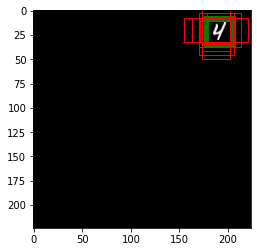

In [19]:
# checking if the inputs prepared are correct or not
r = np.random.randint(0,train_x.shape[0])
img = train_x[r,:,:,:].copy()
img_y = train_y[r]

im = np.array(Image.fromarray(img.astype(np.uint8)))
fig,ax = plt.subplots(1)
ax.imshow(im)

# find all boxes where class label is not background
idx = np.argwhere(img_y[:,0] != NUM_CLASSES)[:,0]
print('Number of boxes with IoU > 0.5:',idx.shape[0])
print('Green box: ground truth. Red box: default boxes with IoU > threshold')

#calculating the ground truth bounding boxes
gt = np.zeros(4,dtype=np.uint16)
gt[:2] = (img_y[idx[0],1:3] + centres[idx[0],:2])
gt[2:] = (img_y[idx[0],3:] + hw[idx[0],:])

# for some reason, x and y are inverted
rect = patches.Rectangle((gt[1]-gt[3]/2,gt[0]-gt[2]/2),gt[3],gt[2],linewidth=5,edgecolor='g',facecolor='none')
ax.add_patch(rect)

# showing all the boxes with IoU > 0.5
for i in idx:
  rect = patches.Rectangle((centres[i][1]-hw[i,1]/2, centres[i][0]-hw[i,0]/2), hw[i,1], hw[i,0], linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

plt.show()

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

print(train_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(224, 224, 3), dtype=tf.float64, name=None), TensorSpec(shape=(3150, 5), dtype=tf.float64, name=None))
(TensorSpec(shape=(224, 224, 3), dtype=tf.float64, name=None), TensorSpec(shape=(3150, 5), dtype=tf.float64, name=None))


2022-02-15 19:10:04.611873: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 722534400 exceeds 10% of free system memory.


In [21]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 60

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

## LOSS FUNCTION
Hard negative mining hasn't been done here
Initial idea was to assign weights to background classes, but there is some problem in that approach

In [ ]:
# label is not required here in the standard implementation
# calculate the smooth L1 loss
def smoothL1(x,y,label):
  diff = K.abs(x-y) #* K.switch(label == 10, label*1.0/BOXES, label)
  result = K.switch(diff < 1, 0.5 * diff**2, diff - 0.5)

  return K.mean(result)


def confidenceLoss(y,label):
  unweighted_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(label, y)
  # class_weights = tf.constant([[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0/BOXES]]*BOXES])
  # weights = tf.reduce_sum(class_weights * y, axis = -1)
  # weighted_loss = unweighted_loss * weights

  return K.mean(unweighted_loss)


def Loss(gt,y):
  # shape of y is n * BOXES * output_channels
  # shape of gt is n * BOXES * 5 
  loss = 0
  # localisation loss
  loss += smoothL1(y[:,:,-4:],gt[:,:,-4:],gt[:,:,0:1])
  # confidence loss
  loss += confidenceLoss(y[:,:,:-4],tf.cast(gt[:,:,0],tf.int32))

  return loss

## TRAIN MODEL

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss=Loss)
history = model.fit(train_dataset, epochs=2, validation_data=test_dataset)

In [ ]:
## save model
model_name = "pplcntr_" + datetime.now().strftime("%Y%m%d-%H%M%S")
model.save(
  filepath=model_name,
  overwrite=True,
  include_optimizer=True,
  save_format='tf',
  signatures=None,
  options=None,
  save_traces=True,)
# model.save(model_name, save_format='tf')

# ## save weight
# model_weight = "pplcntr_" + dt.now().strftime("%Y%m%d-%H%M%S") + ".h5"
# model.save_weights(model_weight, save_format='h5')

In [ ]:
model.evaluate(test_x, test_y)

## INFERENCE

In [ ]:
# create some sample data
X, Y = convert(x_test, y_test)

In [ ]:
# get prediction for one sample
y_pred = model.predict(X)
print(y_pred.shape)

In [ ]:
OBJperCLASS = 10 # get the top 10 results for each class
# get the confidence scores (with class values) and delta for the boxes. For each class, the top 10 values are used
def infer(Y):
  # classes are actually the index into the default boxes
  classes = np.zeros((OBJperCLASS,outputChannels-4),dtype=np.uint16)
  conf = np.zeros((OBJperCLASS,outputChannels-4))
  delta = np.zeros((OBJperCLASS,outputChannels-4,4))
  class_predictions = softmax(Y[:,:outputChannels-4],axis=1)
  for i in range(outputChannels-4):
    classes[:,i] = Bottleneck.argpartition(class_predictions[:,i],BOXES-1-10,axis=-1)[-OBJperCLASS:]
    conf[:,i] = class_predictions[classes[:,i],i]
    delta[:,i] = Y[classes[:,i],outputChannels-4:]

  return conf,classes, delta


# generate bounding boxes from the inferred outputs
def Bbox(confidence,box_idx,delta):
  #delta contains delta(cx,cy,h,w)
  bbox_centre = np.zeros((OBJperCLASS,outputChannels-4,2))
  bbox_hw = np.zeros((OBJperCLASS,outputChannels-4,2))
  for i in range(OBJperCLASS):
    bbox_centre[i,:,0] = centres[box_idx[i]][:,0]+delta[i,:,0]
    bbox_centre[i,:,1] = centres[box_idx[i]][:,1]+delta[i,:,1]
    bbox_hw[i,:,0] = hw[box_idx[i]][:,0] + delta[i,:,2]
    bbox_hw[i,:,1] = hw[box_idx[i]][:,1]+delta[i,:,3]

  return bbox_centre,bbox_hw

In [ ]:
r = np.random.randint(TESTSIZE)

# top 10 predictions for each class
confidence, box_idx, delta = infer(y_pred[r])
bbox_centre,bbox_hw = Bbox(confidence, box_idx, delta)

im = np.array(Image.fromarray(X[r].astype(np.uint8)))
fig,ax = plt.subplots(1)
ax.imshow(im)

for i in range(outputChannels-4):
  # skipping backgrounds
  if i == NUM_CLASSES:
    continue
  color = 'r'
  # if a class is mentioned in the ground truth, color the boxes green
  if i in Y[r,:,0]:
    color = 'g'
    print(i)
  
  # skip all the classes which have low confidence values
  if (confidence[:,i] > 0.5).any() or i in Y[r,:,0]:
    for k in range(OBJperCLASS):
      print("{}: Confidence-{}\t\tCentre-{} Height,Width-{}".format(i,confidence[k,i],bbox_centre[k,i],bbox_hw[k,i]))
      
      # draw bounding box only if confidence scores are high
      if confidence[k,i] < 0.5:
        continue
      x = bbox_centre[k,i,0] - bbox_hw[k,i,0]/2
      y = bbox_centre[k,i,1] - bbox_hw[k,i,1]/2
      rect = patches.Rectangle((y,x),bbox_hw[k,i,1],bbox_hw[k,i,0],linewidth=1,edgecolor=color,facecolor='none')
      ax.add_patch(rect)

plt.show()